6 comb

* vectorization: 
    a. bow
    b. tfidf
    * feature selection
        a. chi2
        b. f-test
        c. mi
        models:
            # logistic: 1008 comb
            # svm: 2688
            # rf: 8000
            
            
total: 82560 combs
lots of 5 cross validation = g


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import re
from data_cleaning import *
import warnings

warnings.filterwarnings('ignore')

# 1. Preprocessing

In [2]:
# read data
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

In [3]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]
X_test_raw = [x[0] for x in test_data[['text']].values]

#### (1). data cleaning

In [4]:
# 1. data cleaning (optional)
X_train_need_to_clean = pd.DataFrame(X_train_raw)
X_test_need_to_clean = pd.DataFrame(X_test_raw)

# remove url, # and @
X_train_need_to_clean.replace("\b*https?:\S*", '', regex=True, inplace=True)
X_train_need_to_clean.replace("\b*@\S*", '', regex=True, inplace=True)
X_train_need_to_clean.replace("\b*#\S*", '', regex=True, inplace=True)
X_test_need_to_clean.replace("\b*https?:\S*", '', regex=True, inplace=True)
X_test_need_to_clean.replace("\b*@\S*", '', regex=True, inplace=True)
X_test_need_to_clean.replace("\b*#\S*", '', regex=True, inplace=True)

for i in range(X_train_need_to_clean.shape[0]):
    X_train_need_to_clean.loc[i, 0] = ' '.join(text_preprocessing(X_train_need_to_clean.loc[i, 0], remove_html=False))

for i in range(X_test_need_to_clean.shape[0]):
    X_test_need_to_clean.loc[i, 0] = ' '.join(text_preprocessing(X_test_need_to_clean.loc[i, 0], remove_html=False))    

X_train_need_to_clean.replace('[^\w\s]','', regex=True, inplace=True)
X_test_need_to_clean.replace('[^\w\s]','', regex=True, inplace=True)
    
    
X_train_clean = [x[0] for x in X_train_need_to_clean[[0]].values]
X_test_clean = [x[0] for x in X_test_need_to_clean[[0]].values]

#### (2). vectorization (transformation)

In [5]:
#TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)
X_train_tranformed, X_test_transformed = X_train_tfidf, X_test_tfidf


# 2. feature selection

### type of selector (choose one of them)

In [6]:
# chi2     
selector = SelectKBest(chi2,k=15000)
X_train_new = selector.fit_transform(X_train_tranformed,Y_train)
X_test_new = selector.transform(X_test_transformed)

# 3. training

### split data for validation

In [7]:
train_size = X_train_tranformed.shape[0]
test_size = X_test_transformed.shape[0]
## random hold out
ts = test_size/train_size
X_train_s, X_validation, y_train_s, y_validation = train_test_split(X_train_new,Y_train, test_size=ts)

In [8]:
cv = round(X_train_s.shape[0] / X_validation.shape[0])

## base model: 0R

In [9]:
clf = DummyClassifier(strategy='most_frequent')
basemodel = clf.fit(X_train_raw, Y_train)
print("base model score: ", basemodel.score(X_train_raw, Y_train))

base model score:  0.5806348041464086


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

## naive bayes

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

# gussian
gnb = GaussianNB()
gnb.fit(X_train_s.toarray(), y_train_s)
gnb.score(X_validation.toarray(), y_validation)
print("Gaussian: ", gnb.score(X_validation.toarray(), y_validation))

# multinomial
mnb = MultinomialNB()
mnb.fit(X_train_s.toarray(), y_train_s)
mnb.score(X_validation.toarray(), y_validation)
print("multinomial: ", mnb.score(X_validation.toarray(), y_validation))

# complement
cnb = ComplementNB()
cnb.fit(X_train_s.toarray(), y_train_s)
cnb.score(X_validation.toarray(), y_validation)
print("complement: ", cnb.score(X_validation.toarray(), y_validation))

# bernoulli
bnb = BernoulliNB()
bnb.fit(X_train_s.toarray(), y_train_s)
print("bernoulli: ", bnb.score(X_validation.toarray(), y_validation))

# # categorical
# canb = CategoricalNB()
# canb.fit(X_train_s.toarray(), y_train_s)
# canb.score(X_validation.toarray(), y_validation)
# print("categorical: ", canb.score(X_validation.toarray(), y_validation))

Gaussian:  0.676668306279718
multinomial:  0.5809149040826365
complement:  0.38432529922938186
bernoulli:  0.6191178881783899


In [85]:
pd.DataFrame(y_train_s).value_counts()

neutral     9162
positive    3823
negative    2718
dtype: int64

## decision tree

In [144]:
from sklearn.tree import DecisionTreeClassifier




dt_hyper = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20,2),
    'min_samples_leaf': range(1,10,1),
    'max_features': ['auto', 'log2'],
}

# random method
search_dt = RandomizedSearchCV(DecisionTreeClassifier(class_weight = ), dt_hyper, scoring='f1_weighted', cv=cv, n_iter=800, n_jobs=-1)
dt_result = search_dt.fit(X_train_s, y_train_s)
dt_result.best_params_
dt_result.best_score_

0.4638762344184946

In [145]:
dt_result.best_score_

0.4638762344184946

In [146]:
dt_result.best_params_

{'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 18,
 'criterion': 'gini'}

In [147]:
dt_model = DecisionTreeClassifier(criterion= dt_result.best_params_['criterion'], max_depth=dt_result.best_params_['max_depth'],
                                  min_samples_leaf=dt_result.best_params_['min_samples_leaf'],
                                  max_features=dt_result.best_params_['max_features'], class_weight = class_weight).fit(X_train_s, y_train_s)

## logistic regression

In [154]:
from sklearn.linear_model import LogisticRegression

logi_hyper = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'none', 'elasticnet'],
    'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'class_weight': [{'negative': x, 'positive': x-2, 'neutral': 1}for x in range(4,15)]
}

search_logi = RandomizedSearchCV(LogisticRegression(n_jobs=-1, class_weight = class_weight),logi_hyper, scoring='f1_weighted', cv=cv, n_iter=101, n_jobs=-1)
logi_result = search_logi.fit(X_train_s, y_train_s)

pd.DataFrame(logi_result.cv_results_)
print(logi_result.best_params_)
print(logi_result.best_score_)

{'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'auto', 'max_iter': 200, 'class_weight': {'negative': 4, 'positive': 2, 'neutral': 1}, 'C': 1}
0.6312997438323686


### SVM

In [51]:
from sklearn.svm import SVC

svm_hyper = {
    'degree': [3, 5, 10, 15],
    'gamma': [1,0.1,0.01,0.001],
    'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmod'],
    'max_iter': [100, 500, 1000],
    'decision_function_shape': ['ovo', 'ovr']
}

# random method
search_svm = RandomizedSearchCV(SVC(class_weight = 'balanced'), svm_hyper, scoring='f1_weighted', cv=cv, n_iter=269)
svm_result = search_svm.fit(X_train_s, y_train_s)

pd.DataFrame(svm_result.cv_results_)
print(svm_result.best_params_)
print(svm_result.best_score_)

{'max_iter': 1000, 'kernel': 'linear', 'gamma': 0.1, 'degree': 3, 'decision_function_shape': 'ovo', 'C': 1000}
0.23791558850012218


### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf_hyper = {
    'n_estimators': [90, 100, 115 , 130],
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20,2),
    'min_samples_leaf': range(1,10,1),
    'min_samples_split': range(2,10,2),
    'max_features': ['auto', 'log2']
}

# random method
search_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1, class_weight = 'balanced'), rf_hyper, scoring='accuracy', cv=cv, n_iter=800, n_jobs=-1)
rf_result = search_rf.fit(X_train_s, y_train_s)

pd.DataFrame(rf_result.cv_results_)
print(rf_result.best_params_)
print(rf_result.best_score_)

{'n_estimators': 130, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 16, 'criterion': 'entropy'}
0.6107110623033075


### Stacking

In [160]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

rf_model = RandomForestClassifier(criterion=rf_result.best_params_['criterion'], max_depth=rf_result.best_params_['max_depth'],
                                  max_features='log2', min_samples_leaf=rf_result.best_params_['min_samples_leaf'], 
                                  min_samples_split=rf_result.best_params_['min_samples_split'], n_estimators=rf_result.best_params_['n_estimators'],
                                  random_state=0, class_weight = 'balanced').fit(X_train_s, y_train_s)

svm_model = SVC(degree=svm_result.best_params_['degree'], gamma=svm_result.best_params_['gamma'] ,C=svm_result.best_params_['C'], 
                kernel=svm_result.best_params_['kernel'], max_iter=svm_result.best_params_['max_iter'], 
                decision_function_shape=svm_result.best_params_['decision_function_shape'], class_weight = 'balanced').fit(X_train_s, y_train_s)

logi_model = LogisticRegression(solver=logi_result.best_params_['solver'], penalty=logi_result.best_params_['penalty'],
                                C=logi_result.best_params_['C'], max_iter=logi_result.best_params_['max_iter'],
                                multi_class=logi_result.best_params_['multi_class'], class_weight = {'negative': 4, 'positive': 2, 'neutral': 1}).fit(X_train_s, y_train_s)

estimators = [('rf', rf_model),('svr', svm_model), ('log', logi_model),('dt', dt_model)]

In [161]:
dt_stacking = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(), n_jobs=-1).fit(X_train_s, y_train_s)
dt_stacking.score(X_validation, y_validation)

ValueError: Class label negative not present.

In [ ]:
svm_stacking = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs=-1).fit(X_train_s, y_train_s)
svm_stacking.score(X_validation, y_validation)

In [ ]:
logi_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=200), n_jobs=-1).fit(X_train_s, y_train_s)
logi_stacking.score(X_validation, y_validation)

In [57]:
super_estimator = [('ls', logi_stacking), ('ss', svm_stacking), ('ds', dt_stacking),('log', logi_model) ]
super_stacking = StackingClassifier(estimators=super_estimator, final_estimator=LogisticRegression(max_iter=200,n_jobs=-1)).fit(X_train_s, y_train_s)
super_stacking.score(X_validation, y_validation)                                    

KeyboardInterrupt: 

# 4. Evaluation

### score

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
from mlxtend.evaluate import bias_variance_decomp

# this function will take the model and datas, print the evaluation scores and output the precdtion

def evaluate_model(model_name: str, model, X_validation, y_validation, X_test_new, cv=5):
    # basestic
    print(f"{model_name}: ")

    # validation acc
    validation_scores = cross_val_score(model,X_validation, y_validation, cv=cv)
    vc = np.mean(validation_scores)
    print("Validation accuracy: ", validation_scores)
    
    print("validation acc for each cross:", )

    # predictions for test data
    prediction = model.predict(X_test_new)

    validation_label = model.predict(X_validation)
    
    # individual metrics
    precision_m = precision_score(y_validation,validation_label, average = None)
    print('individual precision is ', precision_m)

    recall_m = recall_score(y_validation,validation_label, average = None)
    print('individual recall is ', recall_m)

    # f1
    f1_m = f1_score(y_validation,validation_label, average = None)
    print('individual f1 is ', f1_m)
    
    # macro metrics
    precision_m = precision_score(y_validation,validation_label, average = 'macro')
    print('macro precision is ', precision_m)

    recall_m = recall_score(y_validation,validation_label, average = 'macro')
    print('macro recall is ', recall_m)

    # f1
    f1_m = f1_score(y_validation,validation_label, average = 'macro')
    print('macro f1 is ', f1_m)


    # weighted metrics
    precision_w = precision_score(y_validation,validation_label, average = 'weighted')
    print('weighted precision is ', precision_w)

    recall_w = recall_score(y_validation,validation_label, average = 'weighted')
    print('weighted recall is ', recall_w)

    # f1
    f1_w = f1_score(y_validation,validation_label, average = 'weighted')
    print('weighted f1 is ', f1_w)
    
#     preds_test = pd.DataFrame(convert_str_to_num(validation_label, convert_dict))
#     y_test = pd.DataFrame(convert_str_to_num(y_validation, convert_dict))
    
#     mean_pred_test = preds_test.mean(axis = 1)
    
#     mse = preds_test.apply(lambda pred_test: mean_squared_error(y_test, pred_test)).mean()

#     bias_squared = mean_squared_error(y_test, mean_pred_test)

#     variance = preds_test.apply(lambda pred_test: mean_squared_error(mean_pred_test, pred_test)).mean()
    
#     print(preds_test)
    
#     print(bias_squared)
#     print(variance)
    print()
    
    
    
    return prediction

## basic models

In [59]:
base_label = evaluate_model("basemodel 0R", basemodel, X_validation, y_validation,X_test_new)
dt_label = evaluate_model("decision tree", dt_model,X_validation, y_validation,X_test_new)
# print(evaluate_model("guassian nb", gnb, X_validation.toarray(), y_validation_numberise, X_test_new.toarray()))

basemodel 0R: 
Validation accuracy:  [0.57295082 0.57295082 0.57377049 0.57377049 0.57342084]
validation acc for each cross:
individual precision is  [0.         0.57337268 0.        ]
individual recall is  [0. 1. 0.]
individual f1 is  [0.         0.72884535 0.        ]
macro precision is  0.19112422801552167
macro recall is  0.3333333333333333
macro f1 is  0.24294845074336527
weighted precision is  0.32875623481076205
weighted recall is  0.573372684046565
weighted f1 is  0.4179000158630341

decision tree: 
Validation accuracy:  [0.58278689 0.58114754 0.57868852 0.5795082  0.57342084]
validation acc for each cross:
individual precision is  [0.6        0.57753479 0.82758621]
individual recall is  [0.00300903 0.99685445 0.02990654]
individual f1 is  [0.00598802 0.73135424 0.057727  ]
macro precision is  0.6683736660496788
macro recall is  0.3432566719352972
macro f1 is  0.265023088835376
weighted precision is  0.647010170040811
weighted recall is  0.5799311362518446
weighted f1 is  0.435

In [156]:
logi_label = evaluate_model("Logistic Regression", logi_model, X_validation, y_validation,X_test_new)
s_label = evaluate_model("SVM", svm_model, X_validation, y_validation,X_test_new)

Logistic Regression: 
Validation accuracy:  [0.6352459  0.62295082 0.61885246 0.62213115 0.62510254]
validation acc for each cross:
individual precision is  [0.66412214 0.66793731 0.71747967]
individual recall is  [0.26178536 0.90191593 0.43987539]
individual f1 is  [0.37553957 0.76748996 0.54538432]
macro precision is  0.6831797089661634
macro recall is  0.5345255578048457
macro f1 is  0.5628046162991472
weighted precision is  0.6803511130574067
weighted recall is  0.6756845384489261
weighted f1 is  0.6449692045523787

SVM: 
Validation accuracy:  [0.30245902 0.29836066 0.31803279 0.30245902 0.32731747]
validation acc for each cross:
individual precision is  [0.5862069  0.55823864 0.2722306 ]
individual recall is  [0.05115346 0.11238204 0.90031153]
individual f1 is  [0.09409594 0.18709831 0.41805294]
macro precision is  0.4722253760810558
macro recall is  0.3546156762036552
macro f1 is  0.23308239820494117
weighted precision is  0.487545317712221
weighted recall is  0.30972290539432695

### bagging models

In [61]:
rf_label = evaluate_model("random forest", rf_model, X_validation, y_validation,X_test_new)

random forest: 
Validation accuracy:  [0.59672131 0.58934426 0.60491803 0.59754098 0.57588187]
validation acc for each cross:
individual precision is  [0.4537037  0.61189031 0.53507014]
individual recall is  [0.14744233 0.83585931 0.33271028]
individual f1 is  [0.22255867 0.70655064 0.41029581]
macro precision is  0.5335547172362594
macro recall is  0.4386706384443473
macro f1 is  0.44646837358693564
weighted precision is  0.565815801583131
weighted recall is  0.5909165436956878
weighted f1 is  0.5494709560280546



### stacking

In [62]:
ss_label = evaluate_model("svm_stacking", svm_stacking, X_validation, y_validation,X_test_new)
dts_label = evaluate_model("dt_stacking", dt_stacking, X_validation, y_validation,X_test_new)
logi_s_label = evaluate_model("logi_stacking", logi_stacking, X_validation, y_validation,X_test_new)

svm_stacking: 
Validation accuracy:  [0.62704918 0.62377049 0.61639344 0.61721311 0.62346185]
validation acc for each cross:
individual precision is  [0.77868852 0.64689975 0.80678466]
individual recall is  [0.19057172 0.95767801 0.34080997]
individual f1 is  [0.30620467 0.77219276 0.47919404]
macro precision is  0.7441243114154812
macro recall is  0.49635323123846925
macro f1 is  0.5191971588495293
weighted precision is  0.710518160585885
weighted recall is  0.6699458927693065
weighted f1 is  0.6189130316689232

dt_stacking: 
Validation accuracy:  [0.32213115 0.35       0.54016393 0.55163934 0.32649713]
validation acc for each cross:
individual precision is  [0.35507246 0.63459309 0.53862213]
individual recall is  [0.29488465 0.78267086 0.32149533]
individual f1 is  [0.32219178 0.70089629 0.40265314]
macro precision is  0.5094292279535325
macro recall is  0.46635028060082157
macro f1 is  0.4752470694947544
weighted precision is  0.563644499450187
weighted recall is  0.5815707493031644

evaluate_model("super stacking", super_stacking, X_validation, y_validation,X_test_new)
plot_confusion_matrix(super_stacking, X_validation, y_validation)
plt.show()

# 5. Error Analysis

In [63]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

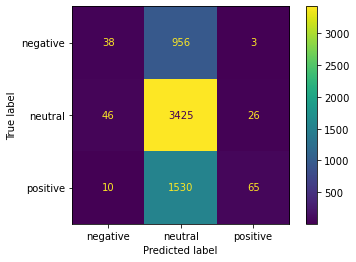

In [148]:
# dt
plot_confusion_matrix(dt_model, X_validation, y_validation)
plt.show()

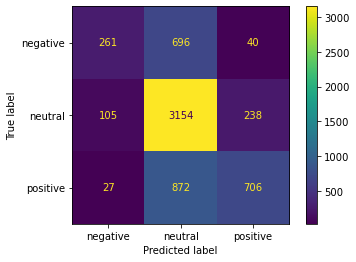

In [157]:
# logistic regression
plot_confusion_matrix(logi_model, X_validation, y_validation)
plt.show()

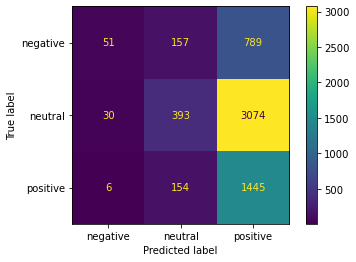

In [65]:
# svm
plot_confusion_matrix(svm_model, X_validation, y_validation)
plt.show()

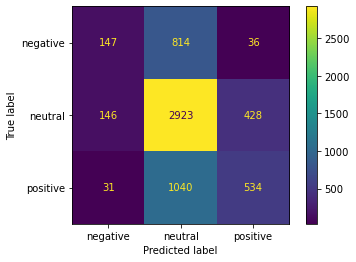

In [66]:
# random forest
plot_confusion_matrix(rf_model, X_validation, y_validation)
plt.show()

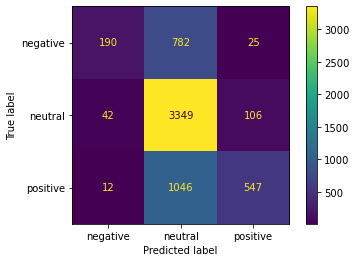

In [67]:
# svm_stacking
plot_confusion_matrix(svm_stacking, X_validation, y_validation)
plt.show()


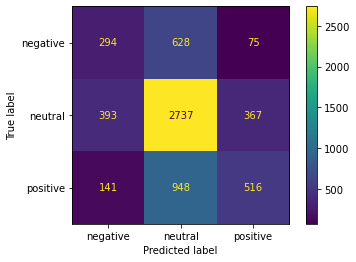

In [68]:
# dt_stacking
plot_confusion_matrix(dt_stacking, X_validation, y_validation)
plt.show()

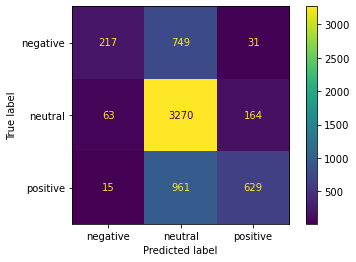

In [69]:
# logi_stacking
plot_confusion_matrix(logi_stacking, X_validation, y_validation)
plt.show()

In [73]:
pd.DataFrame(logi__label).value_counts()

neutral     4997
positive     757
negative     345
dtype: int64

In [75]:
pd.DataFrame(y_train_s).value_counts()

neutral     9162
positive    3823
negative    2718
dtype: int64

## output

import csv


prediction_label = all_positive[0].to_list()
with open('prediction.csv','w') as output:
    output.write("id,sentiment\n")
    for i in range(0,len(prediction_label)):
        output.write(str(test_data['id'].iloc[i]))
        output.write(",")
        output.write(prediction_label[i])
        output.write('\n')

# k fold

In [ ]:
# from sklearn.model_selection import cross_validate
# _scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']


# logi_model = LogisticRegression(solver=logi_result.best_params_['solver'], penalty=logi_result.best_params_['penalty'],
#                                 C=logi_result.best_params_['C'], max_iter=logi_result.best_params_['max_iter'],
#                                 multi_class=logi_result.best_params_['multi_class'], class_weight = 'balanced')

# svm_model = SVC(degree=svm_result.best_params_['degree'], gamma=svm_result.best_params_['gamma'] ,C=svm_result.best_params_['C'], 
#                 kernel=svm_result.best_params_['kernel'], max_iter=svm_result.best_params_['max_iter'], 
#                 decision_function_shape=svm_result.best_params_['decision_function_shape'])

# rf_model = RandomForestClassifier(criterion=rf_result.best_params_['criterion'], max_depth=rf_result.best_params_['max_depth'],
#                                   max_features='log2', min_samples_leaf=rf_result.best_params_['min_samples_leaf'], 
#                                   min_samples_split=rf_result.best_params_['min_samples_split'], n_estimators=rf_result.best_params_['n_estimators'],
#                                   random_state=0)

# # logi_f_result = cross_validate(estimator=logi_model, X=X_train_new, y = Y_train, scoring=_scoring, return_train_score=True,cv=5, error_score="raise")

# estimators = [('rf', rf_model),('svr', svm_model), ('log', logi_model)]

# svm_stacking = StackingClassifier(estimators=estimators, final_estimator=SVC(), n_jobs=-1)
# svm_stacking_f_result = cross_validate(estimator=svm_stacking,X=X_train_new, y = Y_train, scoring=_scoring, return_train_score=True,cv=5, error_score="raise", n_jobs =-1)
